In [82]:
import os
import numpy as np
from PIL import Image
import PIL.ImageOps    
from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import image_registration
from astropy.nddata import Cutout2D
from astropy import units as u
import matplotlib.image as mpimg

from __future__ import print_function
#import cv2
import numpy as np

from photutils import DAOStarFinder
from photutils import CircularAperture
from photutils import aperture_photometry

from astropy.stats import sigma_clipped_stats

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

 
import pandas as pd
import pandasql as ps
plt.style.use(astropy_mpl_style)

In [3]:
def makeFits(inName,imageExtension='.jpg'):
    image = Image.open(inName)
    xsize, ysize = image.size
    print("Image size: {} x {}".format(xsize, ysize))
    # plt.imshow(image)

    r, g, b = image.split()
    r_data = np.array(r.getdata()) # data is now an array of length ysize*xsize
    g_data = np.array(g.getdata())
    b_data = np.array(b.getdata())
    print(r_data.shape)

    r_data = r_data.reshape(ysize, xsize)[::-1]
    g_data = g_data.reshape(ysize, xsize)[::-1]
    b_data = b_data.reshape(ysize, xsize)[::-1]

    inName = inName.replace(imageExtension,'')
    print(inName)
    try:
        os.remove(inName+"red.fits")
        os.remove(inName+"green.fits")
        os.remove(inName+"blue.fits")
    except:
        print("Can't remove as the file doesn't exist")

    red = fits.PrimaryHDU(r_data)
    hdur = fits.HDUList([red])
    hdur.writeto(inName+'red.fits')
    
    green = fits.PrimaryHDU(g_data)
    hdug = fits.HDUList([green])
    hdug.writeto(inName+'green.fits')

    blue = fits.PrimaryHDU(b_data)
    hdub = fits.HDUList([blue])
    hdub.writeto(inName+'blue.fits')

In [191]:
def daoStarFinder(imagename,FWHM=50,thresh=3.):
    """
    Locates and measures the brightness of all objects in the image as well as the sky background
    and other image data.

    :param imagenumber: Position of image in directory
    :return: Table of object data, date of observation, image data for backround calculation
    """
    #print(Image[imagenumber])
    hdu_list = fits.open(imagename) # open image header
    imagedata = (hdu_list[0].data) 
    mean, median, std = sigma_clipped_stats(imagedata, sigma=3.0, iters=5) 
    imagedata[imagedata < 0.75*mean] = 0
    mean, median, std = sigma_clipped_stats(imagedata, sigma=3.0, iters=5) 
#     Median.append(median)
#     STD.append(std)
    print(mean,median,std)
    daofind = DAOStarFinder(fwhm=FWHM, threshold=thresh*std) # iraf star finder 
    Sources = daofind(imagedata - median)
    #Date = (hdu_list[0].header['MJD'])
    output = {}
    output[0] = Sources
#     output[1] = Date
#     output[2] = imagedata
    
    fig, [ax1,ax2] = plt.subplots(1,2,figsize=(10, 10))
    positions = (output[0]['xcentroid'], output[0]['ycentroid'])
    apertures = CircularAperture(positions, r=10.)
    norm = ImageNormalize(stretch=SqrtStretch())
    ax1.imshow(imagedata, cmap='Greys', origin='lower')#norm=norm)
    apertures.plot(color='black', lw=1.5, alpha=0.5)
    #plt.savefig('fits.png',dpi=100)
    ax2.imshow(imagedata, cmap='Greys', origin='lower')
    plt.show()
    
    
    
#     os.chdir(bindingsdirectory)
#     astroprov.provcall([imagenumber],[output[0],output[1],output[2]],"daoStarFinder_PythonCode2Images_SQ_tmpl.provn","daoStarFinder")
#     os.chdir(imagedirectory)
    return output




In [147]:
def assessQuality(output,sqlQuery,refPandasNew):
    pandasTable = Table.to_pandas(output[0])
    newdf = ps.sqldf(sqlQuery,locals())
    if len(newdf) != 0:
        completeness = float(len(newdf))/float(len(refPandasNew))
        accuracy = float(len(newdf))/float(len(pandasTable))
    else:
        print('no objects found')
        completeness = 0
        accuracy = 0
    total = completeness + accuracy
    return [completeness,accuracy,total]

In [ ]:
with open('./molePositions.txt','r') as f:
    data = f.readlines()
    
ycoord = []
xcoord = []
starLocations = []
for x in data[:-1]:
    locator1 = '('
    locator2 = ','
    loc1 = x.index(locator1) +1
    #print(x)
    loc2 = x[loc1:].index(locator2) + loc1 +1
    loc3 = x[loc2:].index(locator2) + loc2
    xcoord.append(x[loc1:loc2-1])
    ycoord.append(x[loc2:loc3])
    #starLocations.append([float(xcoord),float(ycoord)])
tollerance = 5

xUpper = [float(x) + tollerance for x in xcoord]
xLower = [float(x) - tollerance for x in xcoord]
yUpper = [float(x) + tollerance for x in ycoord]
yLower = [float(x) - tollerance for x in ycoord]

refDict = {'index':range(len(xcoord)),'xcoord':xcoord,'ycoord':ycoord,'xUpper':xUpper,'xLower':xLower,
          'yUpper':yUpper,'yLower':yLower}
refPandasNew = pd.DataFrame(data=refDict)

In [139]:
FWHM = range(5,105,5)
thresh = range(1,10)

In [140]:
sqlcode = '''
SELECT *
FROM pandasTable
JOIN refPandasNew
ON pandasTable.xcentroid < refPandasNew.xUpper
AND pandasTable.xcentroid > refPandasNew.xLower
AND pandasTable.ycentroid < refPandasNew.yUpper
AND pandasTable.ycentroid > refPandasNew.yLower
'''

In [133]:
quality = assessQuality(output,sqlcode,refPandasNew)

In [151]:
comp,acc,tot,settings = [],[],[],[]

for fwhm in FWHM:
    for thr in thresh:
        output = daoStarFinder('/home/mj1e16/moleGazer/Photos/F/29018Invertedblue.fits',FWHM=fwhm,thresh=thr)
        quality = assessQuality(output,sqlcode,refPandasNew)
        comp.append(quality[0])
        acc.append(quality[1])
        tot.append(quality[2])
        settings.append([fwhm,thr])

no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found
no objects found


In [155]:
print(acc.index(max(acc)))

98


In [157]:
print(settings[acc.index(max(acc))])
print(settings[comp.index(max(comp))])
print(settings[tot.index(max(tot))])

[55, 9]
[15, 1]
[20, 3]


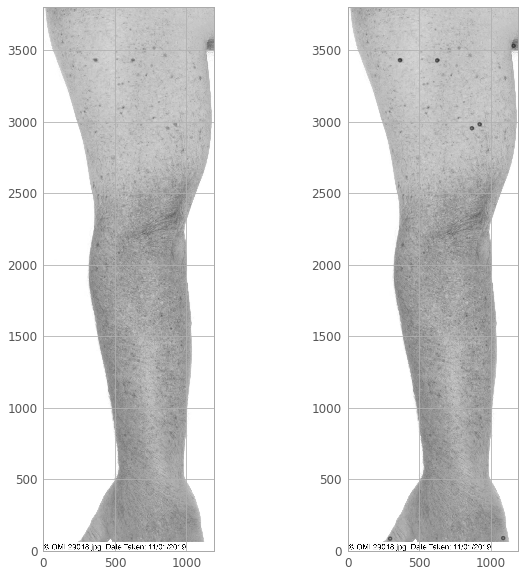

In [159]:
output = daoStarFinder('/home/mj1e16/moleGazer/Photos/F/29018Invertedblue.fits',FWHM=55,thresh=9)

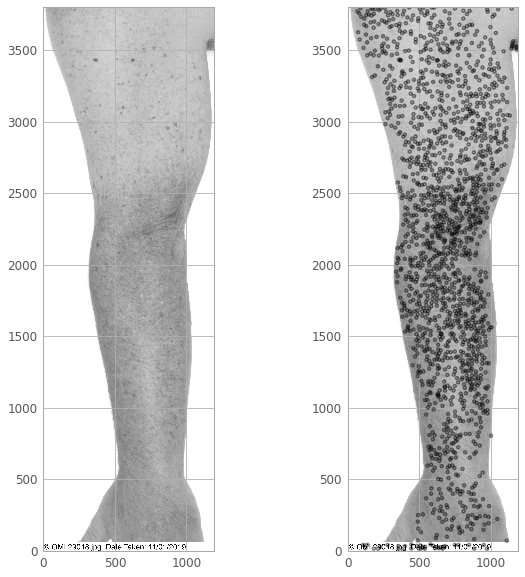

In [160]:
output = daoStarFinder('/home/mj1e16/moleGazer/Photos/F/29018Invertedblue.fits',FWHM=15,thresh=1)

60.60381469095775 85.0 48.90740743315526


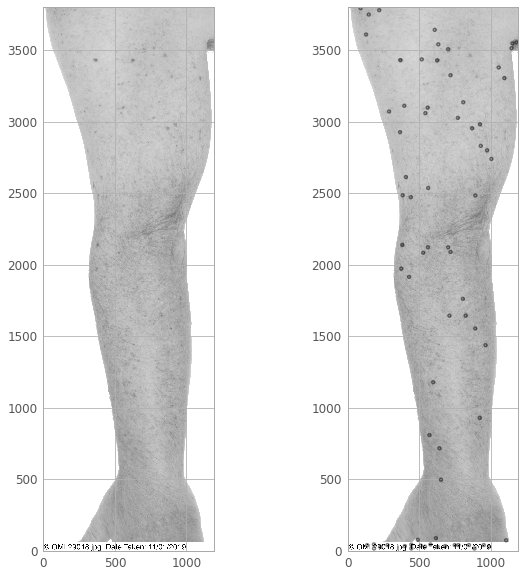

In [193]:
outputref = daoStarFinder('/home/mj1e16/moleGazer/Photos/F/29018Invertedgreen.fits',FWHM=20,thresh=3)

43.595306625182324 0.0 51.36032811380945


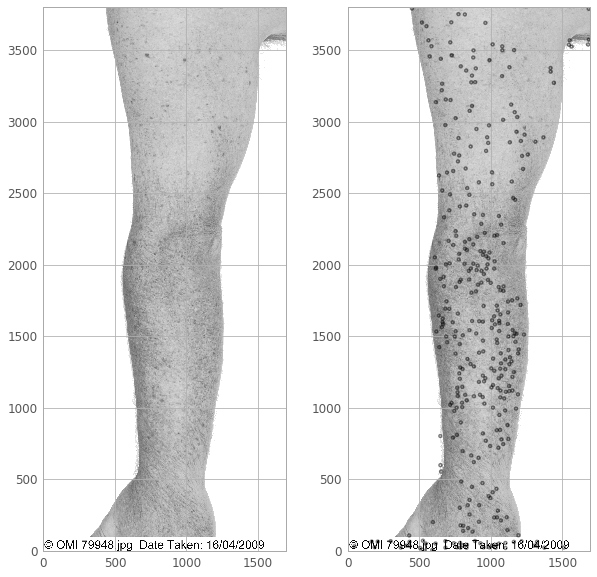

23.319864956995517 0.0 28.110202583683904


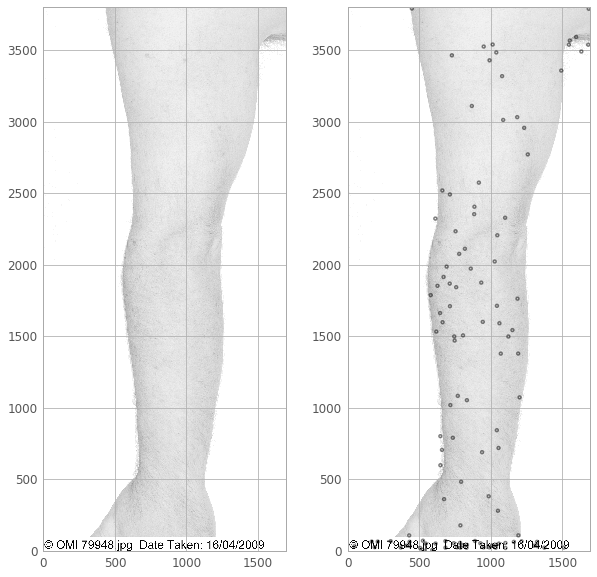

37.688935010539225 0.0 44.16477174977314


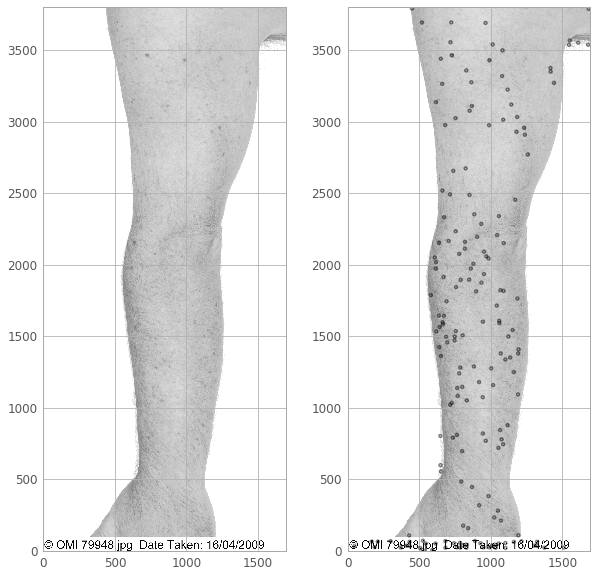

In [195]:
outputAlignBlue = daoStarFinder('/home/mj1e16/moleGazer/Photos/F/79948Invertedblue.fits',FWHM=20,thresh=3)
outputAlignRed = daoStarFinder('/home/mj1e16/moleGazer/Photos/F/79948Invertedred.fits',FWHM=20,thresh=3)
outputAlignGreen = daoStarFinder('/home/mj1e16/moleGazer/Photos/F/79948Invertedgreen.fits',FWHM=20,thresh=3)

In [ ]:
sqlcode = '''
SELECT *
FROM pandasTable
JOIN refPandasNew
ON pandasTable.xcentroid < refPandasNew.xUpper
AND pandasTable.xcentroid > refPandasNew.xLower
AND pandasTable.ycentroid < refPandasNew.yUpper
AND pandasTable.ycentroid > refPandasNew.yLower
'''


In [228]:
outputAlignBlue[0]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,523.4542645234775,5.984829400543886,0.5410807884498511,0.6567488586669945,0.35759599082390614,625.0,0.0,255.0,9.108581613049969,-2.3986268849175008
2,590.8121530788877,5.060917596856952,0.630828477071984,-0.6324151860081901,-0.2888025741436189,625.0,0.0,255.0,8.599367309014466,-2.336166248948554
3,505.3893918835726,19.282372904797647,0.8888823984649967,0.28840870432351756,0.0015035310959816476,625.0,0.0,255.0,7.20455303202561,-2.1440176062663543
4,1102.1952160768935,19.277700128053425,0.8791221887061765,0.24748144489444973,-0.0020486192804041003,625.0,0.0,254.0,7.2465031779273765,-2.1503212175012356
5,682.9272494665627,21.52925837346971,0.43615346653927706,-0.7089949708575286,0.000697537241936738,625.0,0.0,243.0,9.067100754432644,-2.3936711041894494
6,786.8949893446594,21.609253938986967,0.47402990242170107,-0.6286510466908052,0.4682422798634937,625.0,0.0,247.0,9.670356739835762,-2.463606238797065
7,830.1965071381176,21.043685526136564,0.6451028681449171,0.9512467149831335,-0.5077411568337672,625.0,0.0,255.0,8.257801758983451,-2.2921611319203987
8,1374.3099112131804,21.733212091629568,0.364086870511249,0.22494399591119923,-0.13951284582169354,625.0,0.0,240.0,9.894426383351396,-2.4884765540199485
9,1034.2928446556323,21.292759122573248,0.6425926072071523,0.7244108712700111,-0.3875523394367169,625.0,0.0,253.0,8.29040627487471,-2.2964395346425177


In [260]:
def matchTables(table1,table2,tollerance=5):
    sqlcode = '''
    SELECT *
    FROM pandasTable1
    JOIN pandasTable2
    ON pandasTable1.xcentroid < pandasTable2.xUpper
    AND pandasTable1.xcentroid > pandasTable2.xLower
    AND pandasTable1.ycentroid < pandasTable2.yUpper
    AND pandasTable1.ycentroid > pandasTable2.yLower
    '''
    pandasTable1 = Table.to_pandas(table1)
    
    xcoord = table2['xcentroid']
    ycoord = table2['ycentroid']
    flux = table2['flux']
    
    xUpper = [float(x) + tollerance for x in xcoord]
    xLower = [float(x) - tollerance for x in xcoord]
    yUpper = [float(x) + tollerance for x in ycoord]
    yLower = [float(x) - tollerance for x in ycoord]
    

    refDict = {'index':range(len(xcoord)),'xcoord':xcoord,'ycoord':ycoord,'xUpper':xUpper,'xLower':xLower,
              'yUpper':yUpper,'yLower':yLower,'fluxMatch':flux}
    pandasTable2 = pd.DataFrame(data=refDict)
    #print(pandasTable1['xcentroid'])
    newdf = ps.sqldf(sqlcode,locals())
    
    return newdf

In [261]:
matchedObjectsblue = matchTables(outputAlignBlue[0],outputAlignGreen[0])
matchedObjectsgreen = matchTables(outputAlignGreen[0],outputAlignBlue[0])

In [262]:
fluxRatio = [x/y for x,y in zip(matchedObjectsblue['flux'].tolist(),matchedObjectsblue['fluxMatch'].tolist())]

In [263]:
print(np.mean(fluxRatio))
print(np.median(fluxRatio))
print(np.std(fluxRatio))

#change to where I know the mole ratio and not this approximation

1.079952913966468
1.0965451204309062
0.1744347836131872


In [264]:
dropRows = []
medianFlux = np.median(fluxRatio)
stdFlux = np.std(fluxRatio)
print(len(fluxRatio))

for i,x in enumerate(fluxRatio):
    if x > medianFlux + (stdFlux):
        dropRows.append(i)
    if x < medianFlux - (stdFlux):
        dropRows.append(i)
        
print(len(dropRows))

170
79


In [265]:
matchedRefined = matchedObjectsblue.drop(dropRows)

In [241]:
matchedObjectsgreen

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,flux,index,xLower,xUpper,xcentroid,yLower,yUpper,ycentroid
0,1,523.458271,5.975310,0.540258,0.656172,0.358587,625.0,0.0,255.0,10.604424,-2.563718,9.108582,0,518.454265,528.454265,523.454265,0.984829,10.984829,5.984829
1,2,590.802848,5.058189,0.630343,-0.629779,-0.288609,625.0,0.0,255.0,10.001148,-2.500125,8.599367,1,585.812153,595.812153,590.812153,0.060918,10.060918,5.060918
2,3,505.385663,19.272357,0.886640,0.288882,0.003235,625.0,0.0,255.0,8.396855,-2.310292,7.204553,2,500.389392,510.389392,505.389392,14.282373,24.282373,19.282373
3,4,1102.200981,19.269857,0.877335,0.245721,-0.001429,625.0,0.0,254.0,8.441727,-2.316078,7.246503,3,1097.195216,1107.195216,1102.195216,14.277700,24.277700,19.277700
4,5,682.922309,21.524018,0.435823,-0.707262,0.001169,625.0,0.0,243.0,10.547474,-2.557871,9.067101,4,677.927249,687.927249,682.927249,16.529258,26.529258,21.529258
5,6,786.890368,21.587498,0.472530,-0.632579,0.465966,625.0,0.0,247.0,11.257394,-2.628595,9.670357,5,781.894989,791.894989,786.894989,16.609254,26.609254,21.609254
6,7,830.184541,21.041296,0.641512,0.948933,-0.507040,625.0,0.0,255.0,9.646391,-2.460912,8.257802,6,825.196507,835.196507,830.196507,16.043686,26.043686,21.043686
7,8,1374.300228,21.732955,0.362451,0.227819,-0.144642,625.0,0.0,240.0,11.533106,-2.654866,9.894426,7,1369.309911,1379.309911,1374.309911,16.733212,26.733212,21.733212
8,9,1034.311773,21.305708,0.639634,0.723671,-0.390573,625.0,0.0,253.0,9.675211,-2.464151,8.290406,8,1029.292845,1039.292845,1034.292845,16.292759,26.292759,21.292759
9,10,187.766862,25.048665,0.408061,-0.028687,0.460068,625.0,0.0,255.0,11.957448,-2.694096,10.280257,9,182.765643,192.765643,187.765643,20.052569,30.052569,25.052569


In [205]:
matchedObjects['xcentroid'].tolist()

[523.4542645234775,
 590.8121530788877,
 505.3893918835726,
 1102.1952160768935,
 682.9272494665627,
 786.8949893446594,
 830.1965071381176,
 1374.3099112131804,
 1034.2928446556323,
 187.7656426918185,
 370.28031285288773,
 763.6390736106356,
 949.034079523188,
 990.0214538168236,
 1510.7382986732507,
 433.8846604225883,
 1325.102606944662,
 46.902783236813235,
 412.3237352495859,
 1303.3773383557646,
 805.4937843346443,
 1009.071818263434,
 833.2597080871578,
 1036.7299745146108,
 545.2662451771457,
 613.8687061901572,
 1056.700787355708,
 741.4974116545689,
 926.8636871212685,
 1102.1875296089338,
 784.9370918264295,
 1161.0778891535963,
 431.8216057516782,
 1214.9896522962752,
 1323.0529868621252,
 166.97260586819954,
 209.46843689398398,
 300.04769183936963,
 682.694169070945,
 889.5974738224347,
 525.7533339114817,
 429.4003020732847,
 1193.1786275354814,
 841.4064746731361,
 806.7484497658713,
 1071.089059320295,
 1023.6948888549872,
 1049.490449870429,
 919.1568847939831,
 985.

In [266]:
matchedRefined['xcentroid']

41      429.400302
42     1193.178628
43      841.406475
44      806.748450
45     1071.089059
46     1023.694889
47     1049.490450
48      919.156885
49      985.007772
50      868.382776
51      792.819253
54      802.703062
55     1053.448177
58     1074.166078
59      735.279242
61      762.917830
62      944.848120
64     1116.438283
65      716.245081
66      726.249673
68      943.535506
70     1190.112440
71      765.105062
72      800.979200
74      916.895553
76     1161.177669
78      786.230037
80     1101.352863
81     1134.201565
82     1069.511633
          ...     
120     818.592205
121    1089.302282
124     905.023939
125    1044.211637
126     754.322896
127     933.573993
128     673.635536
129    1056.431221
131    1171.042874
132     850.322301
133     714.635020
135     737.018464
136     823.857518
137    1258.658927
140     987.357510
141     681.581814
142    1086.147487
148     616.761413
149     659.595455
150    1440.946636
154     828.256148
155    1417.

In [ ]:
def findAndRefine(image,fwhm=20,thr=3):
    imShort = image[:image.index('.jpg')]
    
    imagedata = Image.open(image)
    inverted_image = PIL.ImageOps.invert(imagedata)
    inverted_image.save(imShort+'Inverted.jpg')
    makeFits(imShort+'Inverted.jpg')
    imGreen,imBlue,imRed = imShort+'Invertedgreen.fits',imshort+'Invertedblue.fits',imshort+'Invertedred.fits'
    
    outputAlignBlue = daoStarFinder(imBlue,FWHM=fwhm,thresh=thr)
    outputAlignRed = daoStarFinder(imRed,FWHM=fwhm,thresh=thr)
    outputAlignGreen = daoStarFinder(imGreen,FWHM=fwhm,thresh=thr)
    
    matchedObjects = matchTables(outputAlignBlue[0],outputAlignGreen[0])
    
    fluxRatio = [x/y for x,y in zip(matchedObjects['flux'].tolist(),matchedObjects['fluxMatch'].tolist())]
    
    dropRows = []
    medianFlux = np.median(fluxRatio)
    stdFlux = np.std(fluxRatio)
    print(len(fluxRatio))

    for i,x in enumerate(fluxRatio):
        if x > medianFlux + (stdFlux):
            dropRows.append(i)
        if x < medianFlux - (stdFlux):
            dropRows.append(i)

    matchedRefined = matchedObjectsblue.drop(dropRows)
    
    

In [268]:
im = '/home/mj1e16/moleGazer/Photos/F/79948Invertedblue.fits'
im.index('.fits')
print(im[:im.index('.fits')])

/home/mj1e16/moleGazer/Photos/F/79948Invertedblue


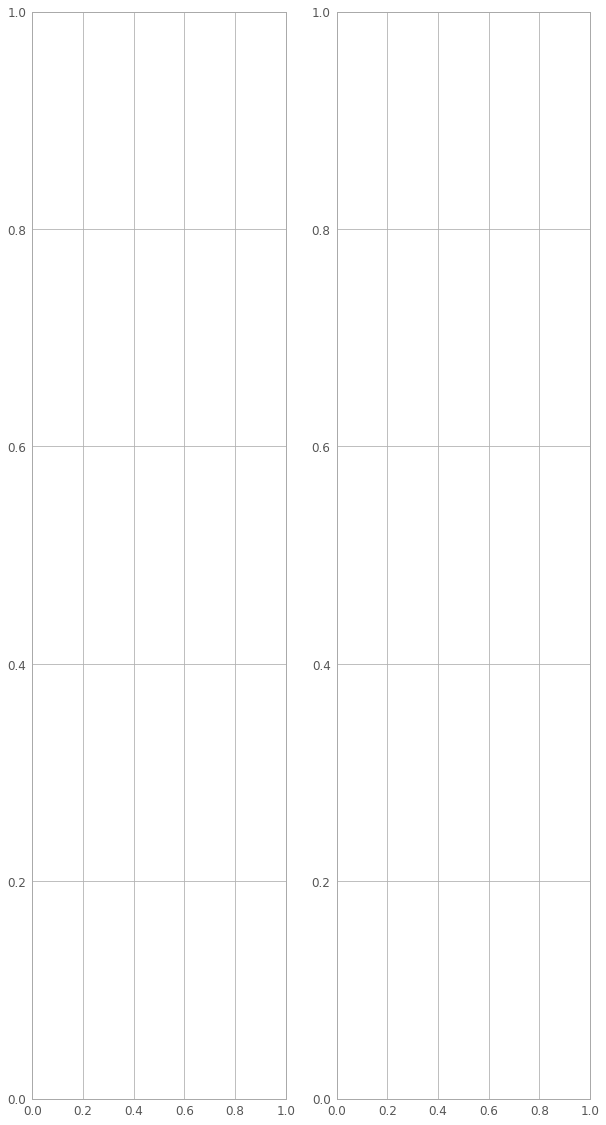

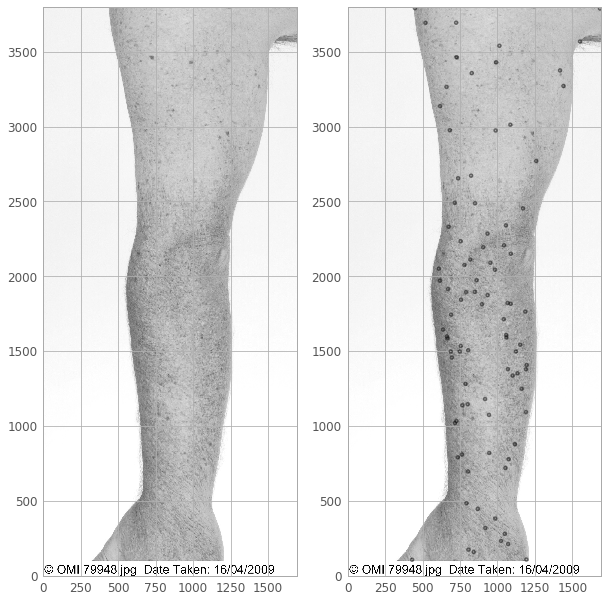

In [267]:
hdu_list = fits.open('/home/mj1e16/moleGazer/Photos/F/79948Invertedblue.fits')
imagedata = (hdu_list[0].data)

fig, [ax1,ax4] = plt.subplots(1,2,figsize=(10, 20))

positions = (matchedRefined['xcentroid'].tolist(), matchedRefined['ycentroid'].tolist())
apertures = CircularAperture(positions, r=10.)
apertures.plot(color='black', lw=1.5, alpha=0.5)

#positions = (outputAlignBlue[0]['xcentroid'], outputAlignBlue[0]['ycentroid'])
#apertures = CircularAperture(positions, r=10.)
norm = ImageNormalize(stretch=SqrtStretch())
ax1.imshow(imagedata, cmap='Greys', origin='lower')#norm=norm)
#apertures.plot(color='blue', lw=1.5, alpha=0.5)
#plt.savefig('fits.png',dpi=100)
#ax2.imshow(imagedata, cmap='Greys', origin='lower')

# positions = (outputAlignGreen[0]['xcentroid'], outputAlignGreen[0]['ycentroid'])
# apertures = CircularAperture(positions, r=10.)
# apertures.plot(color='green', lw=1.5, alpha=0.5)
#ax3.imshow(imagedata, cmap='Greys', origin='lower')

# positions = (matchedObjects['xcentroid'].tolist(), matchedObjects['ycentroid'].tolist())
# apertures = CircularAperture(positions, r=10.)
# apertures.plot(color='black', lw=1.5, alpha=0.5)
ax4.imshow(imagedata, cmap='Greys', origin='lower')

plt.show()

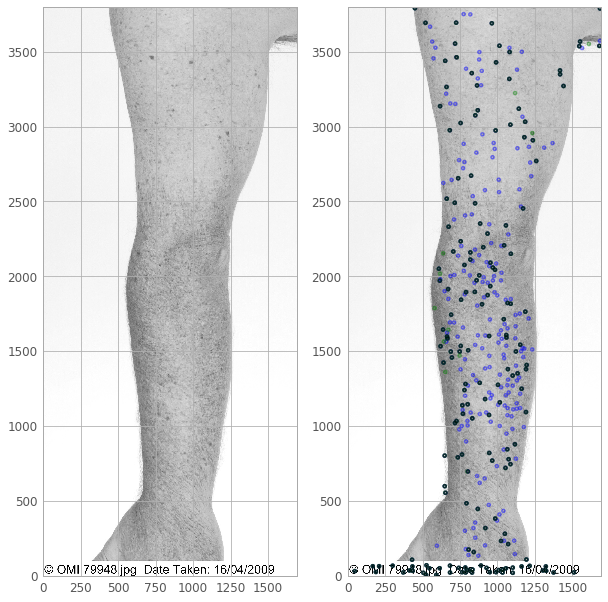

In [215]:
hdu_list = fits.open('/home/mj1e16/moleGazer/Photos/F/79948Invertedblue.fits')
imagedata = (hdu_list[0].data)

fig, [ax1,ax4] = plt.subplots(1,2,figsize=(10, 20))

positions = (matchedObjects['xcentroid'].tolist(), matchedObjects['ycentroid'].tolist())
apertures = CircularAperture(positions, r=10.)
apertures.plot(color='black', lw=1.5, alpha=0.5)

positions = (outputAlignBlue[0]['xcentroid'], outputAlignBlue[0]['ycentroid'])
apertures = CircularAperture(positions, r=10.)
norm = ImageNormalize(stretch=SqrtStretch())
ax1.imshow(imagedata, cmap='Greys', origin='lower')#norm=norm)
apertures.plot(color='blue', lw=1.5, alpha=0.5)
#plt.savefig('fits.png',dpi=100)
#ax2.imshow(imagedata, cmap='Greys', origin='lower')

positions = (outputAlignGreen[0]['xcentroid'], outputAlignGreen[0]['ycentroid'])
apertures = CircularAperture(positions, r=10.)
apertures.plot(color='green', lw=1.5, alpha=0.5)
#ax3.imshow(imagedata, cmap='Greys', origin='lower')

positions = (matchedObjects['xcentroid'].tolist(), matchedObjects['ycentroid'].tolist())
apertures = CircularAperture(positions, r=10.)
apertures.plot(color='black', lw=1.5, alpha=0.5)
ax4.imshow(imagedata, cmap='Greys', origin='lower')

plt.show()

In [203]:
matchedObjects

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,index,xLower,xUpper,xcoord,yLower,yUpper,ycoord
0,1,523.454265,5.984829,0.541081,0.656749,0.357596,625.0,0.0,255.0,9.108582,-2.398627,0,518.458271,528.458271,523.458271,0.975310,10.975310,5.975310
1,2,590.812153,5.060918,0.630828,-0.632415,-0.288803,625.0,0.0,255.0,8.599367,-2.336166,1,585.802848,595.802848,590.802848,0.058189,10.058189,5.058189
2,3,505.389392,19.282373,0.888882,0.288409,0.001504,625.0,0.0,255.0,7.204553,-2.144018,2,500.385663,510.385663,505.385663,14.272357,24.272357,19.272357
3,4,1102.195216,19.277700,0.879122,0.247481,-0.002049,625.0,0.0,254.0,7.246503,-2.150321,3,1097.200981,1107.200981,1102.200981,14.269857,24.269857,19.269857
4,5,682.927249,21.529258,0.436153,-0.708995,0.000698,625.0,0.0,243.0,9.067101,-2.393671,4,677.922309,687.922309,682.922309,16.524018,26.524018,21.524018
5,6,786.894989,21.609254,0.474030,-0.628651,0.468242,625.0,0.0,247.0,9.670357,-2.463606,5,781.890368,791.890368,786.890368,16.587498,26.587498,21.587498
6,7,830.196507,21.043686,0.645103,0.951247,-0.507741,625.0,0.0,255.0,8.257802,-2.292161,6,825.184541,835.184541,830.184541,16.041296,26.041296,21.041296
7,8,1374.309911,21.733212,0.364087,0.224944,-0.139513,625.0,0.0,240.0,9.894426,-2.488477,7,1369.300228,1379.300228,1374.300228,16.732955,26.732955,21.732955
8,9,1034.292845,21.292759,0.642593,0.724411,-0.387552,625.0,0.0,253.0,8.290406,-2.296440,8,1029.311773,1039.311773,1034.311773,16.305708,26.305708,21.305708
9,10,187.765643,25.052569,0.408333,-0.027755,0.456589,625.0,0.0,255.0,10.280257,-2.530010,9,182.766862,192.766862,187.766862,20.048665,30.048665,25.048665


In [176]:
testTab = outputref[0]
testTab.sort(['flux'])
testTab[-10:]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5,627.3920862990218,26.038236461932872,0.5637979193737225,0.12453383458899785,0.19556931025005111,625.0,0.0,157.0,6.501524906724721,-2.032538076570538
18,577.8131523575099,43.97349801527524,0.6953597381518027,0.10662510674977643,-0.24315201255619334,625.0,0.0,166.0,6.528465874901386,-2.0370278458594866
3,885.7751535034022,15.36198660880476,0.2850426104480873,0.2711485314705145,-0.27789121595125693,625.0,0.0,71.0,7.632577880534065,-2.2066781110096607
2,183.5405640927984,15.368767075150496,0.23885204435744156,0.11069731127824345,-0.25671906037013253,625.0,0.0,59.0,7.71987937499033,-2.2190262860772436
10,510.51116325920333,35.59162792473742,0.6274265599753783,0.0678571801854997,0.7630589377181599,625.0,0.0,164.0,8.030637254193353,-2.2618750229098907
14,847.092436484992,39.40325237529901,0.46783956122340686,0.07509304523870841,0.37568995284151185,625.0,0.0,125.0,8.19502383832601,-2.2838755530452413
12,747.778748084736,39.4571788416378,0.42892900071800144,0.04920964660439502,0.25165218488218544,625.0,0.0,115.0,8.303786011772536,-2.2981903722436696
13,773.308719522813,39.42172247332026,0.4065572058518243,0.1257875278008594,0.3418358855040022,625.0,0.0,109.0,8.3209138961651,-2.300427570013086
11,277.6318894687271,39.426136269057736,0.4632973486839264,0.020353618421661144,0.2792814063820697,625.0,0.0,127.0,8.33768026040138,-2.3026130911499982


In [177]:
testTab = outputAlign[0]
testTab.sort(['flux'])
testTab[-10:]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8,1374.298050818145,21.772663809304763,0.3609206638823551,0.22968527384807844,-0.14918562404610658,625.0,0.0,229.0,33.088098452235805,-3.799179523261481
26,613.8380346225225,50.22707383850015,0.43089787459526585,-0.5974370681476533,0.7253891746800405,625.0,0.0,244.0,33.381283111284894,-3.8087575652379972
32,1161.0345681152564,61.96161427572621,0.3926606375609428,0.5952870708241389,0.513650749118397,625.0,0.0,242.0,33.529142909695814,-3.813556129743603
31,784.9453299497721,55.101695680153014,0.33509862599422985,0.09592311278426989,0.6013042214412325,625.0,0.0,233.0,33.95322145656827,-3.8272024652775505
25,545.2884676155232,49.93567837025846,0.40867123609213063,0.5258165729627511,0.6745984030816025,625.0,0.0,244.0,34.270602456537155,-3.8373043478305684
10,187.76048996489442,25.06206737463084,0.40433259280248623,-0.02665585629132829,0.4500719254313314,625.0,0.0,244.0,34.488555707716934,-3.8441875190221024
35,1323.0239497282696,62.10290023202951,0.3880261215414874,0.6217730300574228,0.7935381015646722,625.0,0.0,244.0,34.98602551995201,-3.85973652148353
33,431.84784791426324,62.17318815219604,0.38877717268787126,0.6328456930114712,0.806831070459675,625.0,0.0,244.0,35.12806354888646,-3.8641355244079993
37,209.45263305833373,63.841912823518406,0.3313102544506946,0.42044680442595045,0.7897999970110001,625.0,0.0,242.0,37.50880229111712,-3.935332991844191


In [146]:
comp,acc,tot,settings = [],[],[],[]

for fwhm in range(10,15):
    for thr in range(1,3):
        output = daoStarFinder('/home/mj1e16/moleGazer/Photos/F/29018Invertedblue.fits',FWHM=fwhm,thresh=thr)
        quality = assessQuality(output,sqlcode,refPandasNew)
        comp.append(quality[0])
        acc.append(quality[1])
        tot.append(quality[2])
        settings.append([fwhm,thr])

In [150]:
tot

[0.732340140609307,
 0.2594880847308032,
 0.7836098969816527,
 0.3839112343966713,
 0.8254038241404164,
 0.5236173230064362,
 0.8235400407252712,
 0.6696855528184321,
 0.7672592668493993,
 0.700370464997445]

In [5]:
imageRefernce = '/home/mj1e16/moleGazer/Photos/F/29018.jpg'
imageAlign =  '/home/mj1e16/moleGazer/Photos/F/79948.jpg'

makeFits(imageAlign)
makeFits(imageRefernce)

Image size: 1694 x 3800
(6437200,)
/home/mj1e16/moleGazer/Photos/F/79948
Image size: 1190 x 3800
(4522000,)
/home/mj1e16/moleGazer/Photos/F/29018


In [165]:
image = Image.open(imageRefernce)
inverted_image = PIL.ImageOps.invert(image)
inverted_image.save('/home/mj1e16/moleGazer/Photos/F/29018Inverted.jpg')
makeFits('/home/mj1e16/moleGazer/Photos/F/29018Inverted.jpg')

Image size: 1190 x 3800
(4522000,)
/home/mj1e16/moleGazer/Photos/F/29018Inverted


In [166]:
image = Image.open(imageAlign)
inverted_image = PIL.ImageOps.invert(image)
inverted_image.save('/home/mj1e16/moleGazer/Photos/F/79948Inverted.jpg')
makeFits('/home/mj1e16/moleGazer/Photos/F/79948Inverted.jpg')

Image size: 1694 x 3800
(6437200,)
/home/mj1e16/moleGazer/Photos/F/79948Inverted
Can't remove as the file doesn't exist


In [163]:
makeFits('/home/mj1e16/moleGazer/Photos/F/79948Inverted.jpg')

Image size: 1190 x 3800
(4522000,)
/home/mj1e16/moleGazer/Photos/F/29018Inverted


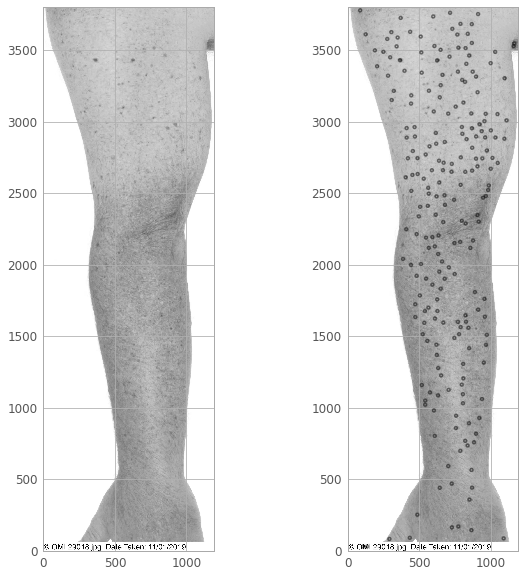

In [65]:
output = daoStarFinder('/home/mj1e16/moleGazer/Photos/F/29018Invertedblue.fits',thresh=2.)

In [74]:
pandasTable = Table.to_pandas(output[0])

In [114]:
tollerance = 5

xUpper = [float(x) + tollerance for x in xcoord]
xLower = [float(x) - tollerance for x in xcoord]
yUpper = [float(x) + tollerance for x in ycoord]
yLower = [float(x) - tollerance for x in ycoord]

refDict = {'index':range(len(xcoord)),'xcoord':xcoord,'ycoord':ycoord,'xUpper':xUpper,'xLower':xLower,
          'yUpper':yUpper,'yLower':yLower}
refPandasNew = pd.DataFrame(data=refDict)

In [120]:
refPandasNew.columns

Index([u'index', u'xLower', u'xUpper', u'xcoord', u'yLower', u'yUpper',
       u'ycoord'],
      dtype='object')

In [129]:
sqlcode = '''
SELECT *
FROM pandasTable
JOIN refPandasNew
ON pandasTable.xcentroid < refPandasNew.xUpper
AND pandasTable.xcentroid > refPandasNew.xLower
AND pandasTable.ycentroid < refPandasNew.yUpper
AND pandasTable.ycentroid > refPandasNew.yLower
'''

In [111]:
sqlcode = 'SELECT id FROM pandasTable WHERE pandasTable.xcentroid BETWEEN refPandas.xUpper AND refPandas.xLower AND pandasTable.ycentroid BETWEEN refPandas.yUpper AND refPandas.yLower'

In [118]:
sqlcode = 'SELECT id FROM pandasTable WHERE pandasTable.ycentroid BETWEEN refPandasNew.yUpper AND refPandasNew.yLower'

In [121]:
sqlcode = 'SELECT xUpper FROM refPandasNew'

In [130]:
newdf = ps.sqldf(sqlcode,locals())

In [131]:
newdf

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,index,xLower,xUpper,xcoord,yLower,yUpper,ycoord
0,44,966.548366,1439.089012,0.718639,-0.218869,0.467994,3969.0,0.0,53.0,2.339513,-0.922814,40,957.71724,967.71724,962.71724,1435.1684,1445.1684,1440.1684
1,84,566.116078,2117.099123,0.308490,-0.793415,0.164738,3969.0,0.0,44.0,2.216429,-0.864134,60,560.36014,570.36014,565.36014,2114.2843,2124.2843,2119.2843
2,118,451.653326,2627.129461,0.987266,0.462276,0.322533,3969.0,0.0,27.0,1.761250,-0.614552,84,449.71392,459.71392,454.71392,2624.5807,2634.5807,2629.5807
3,136,790.299471,2749.810850,0.732136,0.372883,0.223877,3969.0,0.0,18.0,1.990223,-0.747254,97,782.05655,792.05655,787.05655,2742.2407,2752.2407,2747.2407
4,155,867.624138,2953.426998,0.576302,-0.413430,-0.140490,3969.0,0.0,41.0,5.623187,-1.874956,27,859.50804,869.50804,864.50804,2951.6178,2961.6178,2956.6178
5,159,920.496121,2981.082571,0.592945,-0.597669,0.245106,3969.0,0.0,43.0,5.438415,-1.838681,28,912.84137,922.84137,917.84137,2975.7845,2985.7845,2980.7845
6,168,808.534671,3133.067811,0.926226,0.240144,-0.008892,3969.0,0.0,17.0,1.829553,-0.655863,29,801.40700,811.40700,806.407,3132.9667,3142.9667,3137.9667
7,170,307.248824,3150.561004,0.462352,0.512015,-0.084406,3969.0,0.0,13.0,1.526311,-0.459107,33,303.82014,313.82014,308.82014,3147.0579,3157.0579,3152.0579
8,180,896.729879,3314.320200,0.842897,-0.118736,0.319804,3969.0,0.0,34.0,3.460811,-1.347945,48,891.37353,901.37353,896.37353,3308.9910,3318.9910,3313.991
9,182,662.293326,3326.371165,0.944743,-0.114585,-0.278916,3969.0,0.0,36.0,3.133719,-1.240150,93,662.04528,672.04528,667.04528,3322.1117,3332.1117,3327.1117


In [89]:
newdf

,id
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


In [75]:
pandasTable

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
0,1,107.352855,29.462322,0.369447,-0.297692,-0.509726,3969.0,0.0,32.0,16.505556,-3.044075
1,2,135.430763,29.336979,0.342985,0.195085,-0.361784,3969.0,0.0,26.0,18.002022,-3.138303
2,3,291.350672,82.336973,0.350833,0.785474,-0.577397,3969.0,0.0,29.0,14.093059,-2.872513
3,4,433.669527,90.449648,0.303612,0.592968,-0.944454,3969.0,0.0,35.0,10.514286,-2.554449
4,5,1089.809044,86.249421,0.275219,-0.386361,-0.256336,3969.0,0.0,19.0,12.570294,-2.748364
5,6,864.250745,143.812390,0.427128,-0.293358,0.346953,3969.0,0.0,43.0,1.625453,-0.527436
6,7,727.673453,163.323460,0.990003,0.793300,0.631886,3969.0,0.0,53.0,1.667194,-0.554965
7,8,772.877644,169.591894,0.399146,-0.581639,0.660662,3969.0,0.0,46.0,1.622781,-0.525649
8,9,486.601423,251.989883,0.202939,0.156904,0.042508,3969.0,0.0,43.0,1.548182,-0.474555
9,10,850.822763,357.234116,0.235544,-0.933219,-0.300216,3969.0,0.0,35.0,1.505191,-0.443979


In [69]:
makeFits('/home/mj1e16/moleGazer/Photos/F/29018Inverted.jpg')


Image size: 1190 x 3800
(4522000,)
/home/mj1e16/moleGazer/Photos/F/29018Inverted


In [62]:
def convertAgain(inImage,outImage):
    newdata = getImageData(inImage,0)
    red = fits.PrimaryHDU(newdata)
    hdul = fits.HDUList([red])
    red.writeto(outImage)

In [63]:
convertAgain('/home/mj1e16/moleGazer/Photos/F/29018Inverted.jpg','/home/mj1e16/moleGazer/Photos/F/29018Invertedastro.jpg')

IOError: Header missing END card.

In [49]:
from astropy.io import fits
#from astropy.io.ascii import SExtractor
from astropy.stats import sigma_clipped_stats
#from astropy.coordinates import SkyCoord
#import astropy.units as u
#import matplotlib.pyplot as plt
#import numpy as np
import os
# #from photutils import DAOStarFinder
# from photutils import CircularAperture
# from photutils import aperture_photometry
#import subproc

#import numpy as np
#from astropy import wcs
#from astropy.io import fits
#import sys

#from astroquery.simbad import Simbad

#import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.table import Table
#from astropy.table import Column

#import collections
import subprocess
from astropy.io import ascii


In [44]:
def alterDefault(defaultDir,valList,attributeList):
    
    with open(defaultDir+'/default.sex','r') as f:
        data  = f.read()
    for x in range(len(valList)):
        nameLoc = data.find(attributeList[x]) + len(attributeList[x])
        endLoc = data[nameLoc:].find('#') + nameLoc
        newData = data[:nameLoc] + ' '+str(valList[x])+' ' + data[endLoc:]
        data = newData
    
#     with open(defaultDir+'/default.sex','r') as f:
#         endData = f.read()
#     cname = 'CATALOG_NAME'
#     nameLoc = endData.find(cname) + len(cname)
#     endLoc = data[nameLoc:].find('#') + nameLoc
#     newData = data[:nameLoc] + '' + data[endLoc:]
    
    with open(defaultDir+'/default.sex','w') as f:
        f.write(data)

In [72]:
def sextractor(sextractoryDir,imagename,cataloguename,imageDir='/home/mj1e16/moleGazer/Photos/F/'):
    os.chdir(sextractoryDir)
    subprocess.call(['sex',imageDir+imagename])
    assoc = Table.read(cataloguename,format='ascii.sextractor')

    os.chdir(imageDir)
    hdu_list = fits.open(imagename) # open image header
    imagedata = (hdu_list[0].data) 
    
    fig, ax = plt.subplots(figsize=(10, 10))
    positions = (assoc['X_IMAGE'], assoc['Y_IMAGE'])
    print(positions)
    #apertures = CircularAperture(positions, r=4.)
    norm = ImageNormalize(stretch=SqrtStretch())
    ax.imshow(imagedata, cmap='Greys', origin='lower', vmin=-100,vmax=100)#norm=norm)
    #plt.plot(positions,'bo') #,color='blue', lw=1.5, alpha=0.5)
    #plt.savefig('fits.png',dpi=100)
    plt.show()
    
#     print(len(assoc))
#     mags = assoc['MAG_APER']
#     plt.hist(mags,bins='auto')
#     plt.show()
    return assoc

(<Column name='X_IMAGE' dtype='int64' unit='pix' description='Object position along x' length=0>
, <Column name='Y_IMAGE' dtype='int64' unit='pix' description='Object position along y' length=0>
)


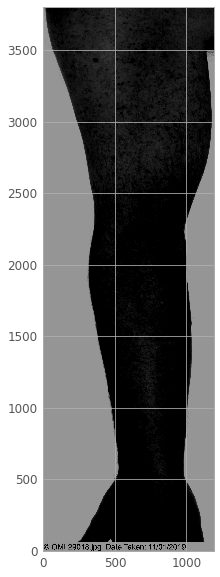

In [73]:
#alterDefault('/home/mj1e16/sextractor/sextractor-master/config/',[x,5,64,3],['DETECT_THRESH','DETECT_MINAREA','BACK_SIZE','BACK_FILTERSIZE'])
sexTabs = sextractor('/home/mj1e16/sextractor/sextractor-master/config/','29018Invertedgreen.fits','testmole.cat')
#makeDS9RegFile(sexTabs,'/home/mj1e16/ds9Tables/sexKepThresh','sex')

In [4]:
def getImageData(imageName,extension):
    hdu = fits.open(imageName)
    imageData = hdu[extension].data
    return imageData

In [5]:
hdu = fits.open('/home/mj1e16/moleGazer/Photos/F/29018blue.fits')

In [6]:
imDataRef = getImageData('/home/mj1e16/moleGazer/Photos/F/29018blue.fits',0)
imDataAlign = getImageData('/home/mj1e16/moleGazer/Photos/F/79948blue.fits',0)

In [7]:
print(imDataAlign.shape)
print(imDataRef.shape)

(3800, 1694)
(3800, 1190)


In [8]:
ylen = imDataAlign.shape[0]
xlen = imDataAlign.shape[1]

In [9]:
print(ylen,xlen)

3800 1694


In [10]:
lower = 410
higher = 1600
# position = ((lower+higher)/2,ylen/2)
# size = (higher-lower,ylen)
position = (lower+((higher-lower)/2),(ylen/2))
size = (ylen,(higher-lower))
cutout = Cutout2D(imDataAlign,position,size)

In [11]:
cutout.shape

(3800, 1190)

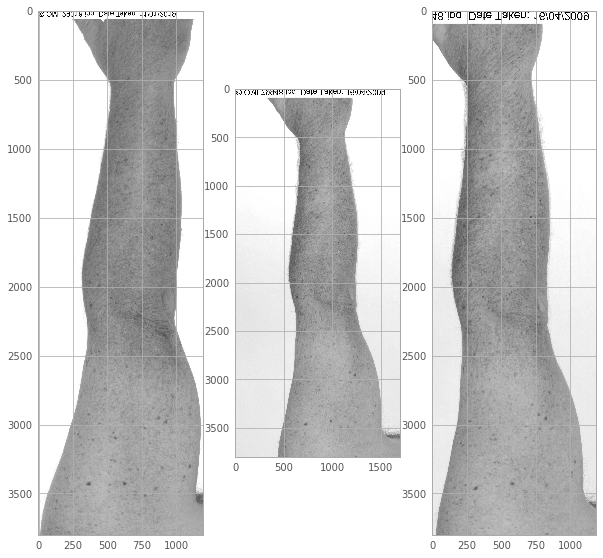

In [12]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,10)) 
ax1.imshow(imDataRef,cmap='gray')
ax2.imshow(imDataAlign,cmap='gray')
ax3.imshow(cutout.data,cmap='gray')
plt.show()

In [13]:
hdu_list = [imDataRef,cutout.data]

In [14]:
shape1 = hdu_list[0].shape
shape2 = hdu_list[1].shape
print(shape1,shape2)

(3800, 1190) (3800, 1190)


In [12]:
def alignImages(hdulist):
#     shaperoni = im1_aligned_to_im2.shape
#     xsegments = int(shaperoni[0]/100)
#     ylen = shaperoni[0] 
    alignedHDU = [hdulist[0]]
    im2 = hdulist[0]
    for image in range(1,len(hdulist)):
        im1 = hdulist[image]
        yoff,xoff = image_registration.cross_correlation_shifts(im1,im2)
        im1_aligned_to_im2 = np.roll(np.roll(im1,int(yoff),1),int(xoff),0)
        alignedHDU.append(im1_aligned_to_im2)

    return alignedHDU


In [15]:
alignedHDU = alignImages(hdu_list)

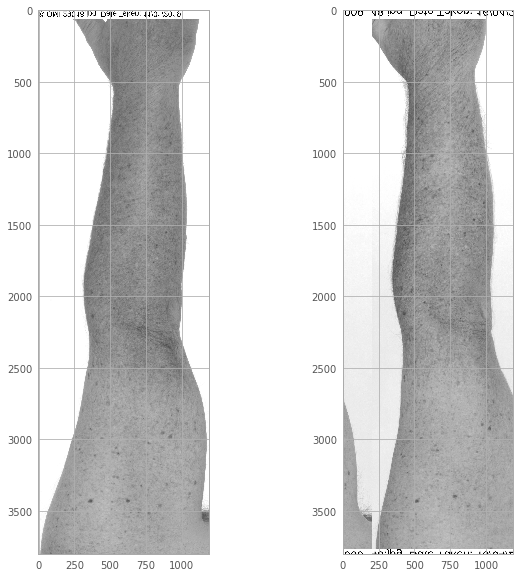

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10)) 
ax1.imshow(alignedHDU[0],cmap='gray')
ax2.imshow(alignedHDU[1],cmap='gray')
plt.show()

In [30]:
from PIL import Image 


imFilename = '/home/mj1e16/moleGazer/Photos/F/29018.jpg'
refFilename =  '/home/mj1e16/moleGazer/Photos/F/79948.jpg'

def crop(imName,prefix):
    im = Image.open(imName)
    width,height = im.size
    print(width,height)
    bottom = 1
    top = height - 100
    left = 1
    right = width -1
    print(bottom,top,left,right)
    #left, top, right, bottom
    im1 = im.crop((1,1,width-1,height-100)) 
    im1.save(prefix+'crop.jpeg')
    
crop(imFilename,'Align')
crop(refFilename,'Ref')

1190 3800
1 3700 1 1189
1694 3800
1 3700 1 1693


In [ ]:
from __future__ import print_function
import cv2
import numpy as np

MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15


imFilename = './Aligncrop.jpeg'
refFilename =  './Refcrop.jpeg'

def alignImages(im1, im2):
 
    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h


# Read reference image
#refFilename = "/Users/pboorman/Dropbox/1_work/2_inprep/1e_molegazer/0_PATIENT_DATA/F/29010/29010"+"ORIGINAL.jpg"
print("Reading reference image : ", refFilename)
imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)

# Read image to be aligned
#imFilename = "/Users/pboorman/Dropbox/1_work/2_inprep/1e_molegazer/0_PATIENT_DATA/F/79941/79941"+"ORIGINAL.jpg"
print("Reading image to align : ", imFilename);  
im = cv2.imread(imFilename, cv2.IMREAD_COLOR)

print("Aligning images ...")
# Registered image will be resotred in imReg. 
# The estimated homography will be stored in h. 
imReg, h = alignImages(im, imReference)

# Write aligned image to disk. 
outFilename = "aligned.jpg"
print("Saving aligned image : ", outFilename); 
cv2.imwrite(outFilename, imReg)

# Print estimated homography
print("Estimated homography : \n",  h)

In [31]:

MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15
 
def alignImages(im1, im2):
 
    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    #print(len(matches))
    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        print(i)
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h

In [37]:

imFilename = './Aligncrop.jpeg'
refFilename =  './Refcrop.jpeg'


#refFilename = imageRefernce
print("Reading reference image : ", refFilename)
imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)

# Read image to be aligned
#imFilename = imageAlign
print("Reading image to align : ", imFilename);  
im = cv2.imread(imFilename, cv2.IMREAD_COLOR)

print("Aligning images ...")
# Registered image will be resotred in imReg. 
# The estimated homography will be stored in h. 
imReg, h = alignImages(im, imReference)

# Write aligned image to disk. 
outFilename = "/home/mj1e16/moleGazer/aligned.jpg"
print("Saving aligned image : ", outFilename); 
cv2.imwrite(outFilename, imReg)

# Print estimated homography
print("Estimated homography : \n",  h)

Reading reference image :  ./Refcrop.jpeg
Reading image to align :  ./Aligncrop.jpeg
Aligning images ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Saving aligned image :  /home/mj1e16/moleGazer/aligned.jpg
Estimated homography : 
 [[ -1.60937205e-01  -1.72080676e-01   6.46371235e+02]
 [ -7.26076706e-01  -7.66952518e-01   2.88541568e+03]
 [ -2.49598630e-04  -2.66132910e-04   1.00000000e+00]]


TypeError: Invalid dimensions for image data

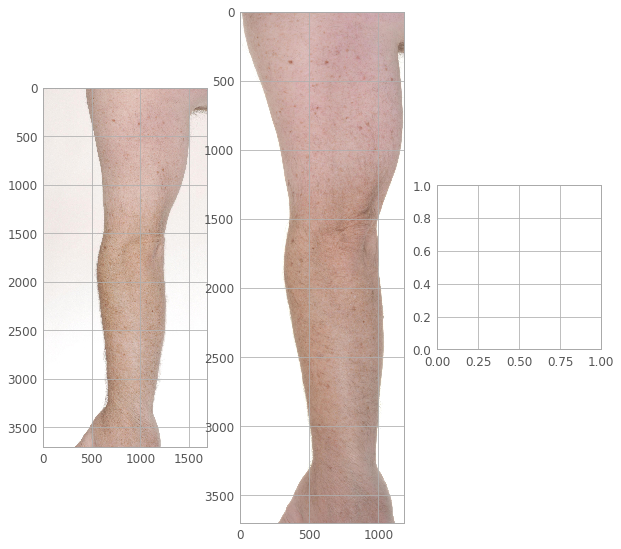

In [38]:
imDataRef = mpimg.imread(refFilename)
imDataAlign = mpimg.imread(imFilename)
cutout = mpimg.imread(outFilename)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,10)) 
ax1.imshow(imDataRef,cmap='gray')
ax2.imshow(imDataAlign,cmap='gray')
ax3.imshow(cutout.data,cmap='gray')
plt.show()

In [39]:
cutout.shape

(3699, 1692, 3)

In [ ]:
image = Image.open('../Photos/A/30536.jpg')
xsize, ysize = image.size
print("Image size: {} x {}".format(xsize, ysize))
# plt.imshow(image)

r, g, b = image.split()
r_data = np.array(r.getdata()) # data is now an array of length ysize*xsize
g_data = np.array(g.getdata())
b_data = np.array(b.getdata())
print(r_data.shape)

r_data = r_data.reshape(ysize, xsize)[::-1]
g_data = g_data.reshape(ysize, xsize)[::-1]
b_data = b_data.reshape(ysize, xsize)[::-1]

try:
    os.remove("fitsFiles/red.fits")
    os.remove("fitsFiles/green.fits")
    os.remove("fitsFiles/blue.fits")
except:
    print("Can't remove as the file doesn't exist")
    
red = fits.PrimaryHDU(data=r_data)
# red.header['LATOBS'] = "32:11:56" # add spurious header info
# red.header['LONGOBS'] = "110:56"
red.writeto('fitsFiles/red.fits')

green = fits.PrimaryHDU(data=g_data)
# green.header['LATOBS'] = "32:11:56"
# green.header['LONGOBS'] = "110:56"
green.writeto('fitsFiles/green.fits')

blue = fits.PrimaryHDU(data=b_data)
# blue.header['LATOBS'] = "32:11:56"
# blue.header['LONGOBS'] = "110:56"
blue.writeto('fitsFiles/blue.fits')

In [44]:
with open('./molePositions.txt','r') as f:
    data = f.readlines()

In [96]:
ycoord = []
xcoord = []
starLocations = []
for x in data[:-1]:
    locator1 = '('
    locator2 = ','
    loc1 = x.index(locator1) +1
    #print(x)
    loc2 = x[loc1:].index(locator2) + loc1 +1
    loc3 = x[loc2:].index(locator2) + loc2
    xcoord.append(x[loc1:loc2-1])
    ycoord.append(x[loc2:loc3])
    #starLocations.append([float(xcoord),float(ycoord)])

In [97]:
xcoord

['367.61031',
 '131.70459',
 '628.57482',
 '864.68593',
 '1103.5979',
 '773.57426',
 '215.40593',
 '419.15035',
 '608.36721',
 '515.24866',
 '135.94193',
 '526.70833',
 '556.22222',
 '598.46759',
 '717.10185',
 '1056.962',
 '559.39175',
 '398.58068',
 '291.76556',
 '78.001585',
 '190.08019',
 '201.2227',
 '246.76882',
 '221.26025',
 '150.26025',
 '511.26025',
 '769.64307',
 '864.50804',
 '917.84137',
 '806.407',
 '755.38648',
 '444.9454',
 '262.33866',
 '308.82014',
 '329.07477',
 '295.20076',
 '352.4373',
 '410.28066',
 '650.5273',
 '573.6937',
 '962.71724',
 '893.48345',
 '826.71904',
 '189.8443',
 '442.3443',
 '299.8443',
 '368.17763',
 '699.65391',
 '896.37353',
 '548.05031',
 '681.96415',
 '489.08752',
 '1091.3542',
 '1090.1542',
 '1004.9542',
 '979.75419',
 '642.55419',
 '389.35419',
 '382.48014',
 '538.00014',
 '565.36014',
 '422.80014',
 '448.72014',
 '370.96014',
 '808.72014',
 '961.36014',
 '991.60014',
 '936.88014',
 '634.10574',
 '988.34574',
 '929.59374',
 '896.76174',
 '8

In [64]:
starLocations

[[367.61031, 3428.1942],
 [131.70459, 3607.5694],
 [628.57482, 3428.8189],
 [864.68593, 3468.4022],
 [1103.5979, 3302.1427],
 [773.57426, 3513.3914],
 [215.40593, 3391.4227],
 [419.15035, 3727.3109],
 [608.36721, 3642.6018],
 [515.24866, 3437.914],
 [135.94193, 3560.04],
 [526.70833, 3261.2256],
 [556.22222, 3268.7488],
 [598.46759, 3278.5867],
 [717.10185, 3328.3552],
 [1056.962, 3378.6509],
 [559.39175, 3099.7922],
 [398.58068, 3117.2299],
 [291.76556, 3069.9914],
 [78.001585, 3757.9066],
 [190.08019, 3499.2839],
 [201.2227, 3593.417],
 [246.76882, 3601.4545],
 [221.26025, 3779.7613],
 [150.26025, 3748.7613],
 [511.26025, 3488.7613],
 [769.64307, 3028.0993],
 [864.50804, 2956.6178],
 [917.84137, 2980.7845],
 [806.407, 3137.9667],
 [755.38648, 3393.9046],
 [444.9454, 2991.0362],
 [262.33866, 3064.8048],
 [308.82014, 3152.0579],
 [329.07477, 3169.419],
 [295.20076, 3390.5601],
 [352.4373, 2552.1851],
 [410.28066, 2608.9868],
 [650.5273, 497.2826],
 [573.6937, 807.6586],
 [962.71724, 14